In [45]:
import sys
sys.path.append("../../Simulations/")

import numpy as np
import matplotlib.pyplot as plt
from skmonaco import mcquad, mcimport, mcmiser
from tqdm import *

from units import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Cumulative SCD calculation

The cumulative SCD can be calculated by integrating over the mass and spatial pdf of subhalos, with a constraint on the integration phase-space:

$$N(>J) = \int_{J(M,\mathbf R) > J} dM\,d^3R \frac{dN}{d\mathbf R dM}.$$

In practice, this is done by integrating over the subhalo mass $M$, the distance from the GC $r$ and the angle between the Galactic plane and line-of-sight from the GC $\theta$ convolved with the subhalo mass function $\rho_M(M)$ and spatial volume distribution $\rho_V(r)$:
$$N(>J) = \int_{J(M,l,\theta) > J} dM\,dr\,d\theta\,\sin(\theta)\,\rho_M(M)\cdot 2\pi r^2 \rho_V(r),$$
where $l^2 = r^2 +R_\odot^2 + 2r R_\odot\,cos(\theta)$ and $R_\odot$ is the Earth-Sun distance. 

Note that the integral can be performed either in Galactocentric coordinates (with $r$ as the integration variable, as we do here) or Galactic coordinates (with line-of-sight distance $l$ as the integration variable). Properly normalized, the answer is the same in either case.

Specify population parameters:

In [84]:
R_sun = 8*kpc

# Minimum and maximum subhalo mass
M_min = 1e4*M_s
M_max = 1e10*M_s

# Minimum and maximum distance from the GC
R_min = 0.1*kpc
R_max = 260*kpc

# Calibrate number of subhalos
M_min_calib = 1e8*M_s
M_max_calib = 1e10*M_s
N_calib = 150.

In [85]:
def rho_M(M, beta=-1.9):
    """ Subhalo mass function
    """
    A0 = 2e8/M_s # Arbitrary, to prevent large numbers and overflow
    return A0*(M/M_s)**beta

def rho_ein_EAQ(r):
    """ Aquarius subhalo radial spatial density, 
        Einasto profile parameterizaton
    """ 
    r_s = 199.*kpc
    alpha_E = 0.678
    return r**2*np.exp(-2/alpha_E*((r/r_s)**alpha_E-1)) 

J-factor calculation:

In [86]:
def J(M200, c200, d):
    """ Annihilation J-factor for NFW halo
    """
    return M200*c200**3*rho_c*200/(9*d**2)*fC(c200)

def fC(c):
    """ Helper function for NFW annihilation J-factor
    """
    return (1 - 1/(1+c)**3)*(np.log(1+c)-c/(1+c))**-2
    
def c200_SC(M200):
    """ Concentration-mass relation according to Eq. 1 of  Sanchez-Conde & Prada 2014 (1312.1729)
    """
    x=np.log(M200/(M_s/h))
    pars=[37.5153, -1.5093, 1.636e-2, 3.66e-4, -2.89237e-5, 5.32e-7][::-1]
    return np.polyval(pars, x)

First, calculate normalization pre-factor to give the specified number of calibration suhalos:

In [87]:
def integrand_norm(x):
    """ Integrand for calculating overall normalization of 
        joint mass-radial distribution pdf
    """ 
    M200, r = np.exp(x[0])*M_s, np.exp(x[1])*kpc
    return 4*np.pi*M200*r*rho_M(M200)*rho_ein_EAQ(r)

norm, norm_err = mcquad(integrand_norm,npoints=1e6,xl=[np.log(M_min_calib/M_s),np.log(R_min/kpc)],xu=[np.log(M_max_calib/M_s),np.log(R_max/kpc)],nprocs=5)
pref = N_calib/norm

Now specify the cumulative SCD integral. The integration is performed in log-space for mass $M_{200}$ and the los distance $l$ for better accuracy, and linear space for angle from GC direction $\theta$.

In [88]:
def rho_M_r(M200, r):
    """ Joint M-R distribution pdf
    """
    return rho_M(M200)*rho_ein_EAQ(r)

def integrand_Ncumul(x, J_fid):
    """ Integrand for calculating cumulative SCD by integrating 
        over the mass function, los distance and angle from GC direction
    """
    M200, r, theta = np.exp(x[0])*M_s, np.exp(x[1])*kpc, x[2]
    
    # If J-factor is greater than specified value, add the corresponding "dN"
    # (impose phase-space constrain)
    l = np.sqrt(r**2 + R_sun**2 + 2*r*R_sun*np.cos(theta))
    if J_fid < J(M200, c200_SC(M200), l)/(GeV**2*Centimeter**-5):
        return 2*np.pi*np.sin(theta)*pref*r*M200*rho_M_r(M200, r)
    else:
        return 0.

Two ways of doing integral:

In [89]:
# J-factor values to calculated cumulative SCD for
J_ary = np.logspace(16,22,30)

### MC integration

In [90]:
# Number of points to use for MC integration (more points = better accuracy + slower)
npoints = 5e5

In [91]:
def Ncumul_MC(J_fid):
    """ Perform cumulative SCD integral with scikit-monaco
    """
    dNdJ_val, dNdJ_err = mcquad(integrand_Ncumul, npoints=npoints, xl=[np.log(M_min/M_s),np.log(R_min/kpc),0], xu=[np.log(M_max/M_s), np.log(R_max/kpc), np.pi], nprocs=5, args=[J_fid])
    return dNdJ_val, dNdJ_err

In [92]:
Ncumul_ary = np.array([Ncumul_MC(J) for J in tqdm_notebook(J_ary)])

### Manual integration

In [93]:
# Number of points to use for manual integration over each 
# dimension (more points = better accuracy + slower)
nlogl = 30
ntheta = 30
nlogM = 30

In [94]:
def Ncumul_manual(J_fid):
    """ Perform cumulative SCD integral manually
    """
    logl_integ_ary = np.linspace(np.log(R_min/kpc), np.log(R_max/kpc), nlogl)
    theta_integ_ary = np.linspace(0, np.pi, ntheta)
    logM_integ_ary = np.linspace(np.log(M_min/M_s), np.log(M_max/M_s), nlogM)

    measure = (logl_integ_ary[1] - logl_integ_ary[0])*(theta_integ_ary[1] - theta_integ_ary[0])*(logM_integ_ary[1] - logM_integ_ary[0])
    integ = 0
    for logl in logl_integ_ary:
        for theta in theta_integ_ary:
            for logM in logM_integ_ary:
                integ += integrand_Ncumul([logM, logl, theta], J_fid)
    integ *= measure

    return integ


In [95]:
Ncumul_manual_ary = np.array([Ncumul_manual(J) for J in tqdm_notebook(J_ary)])

### Plot results

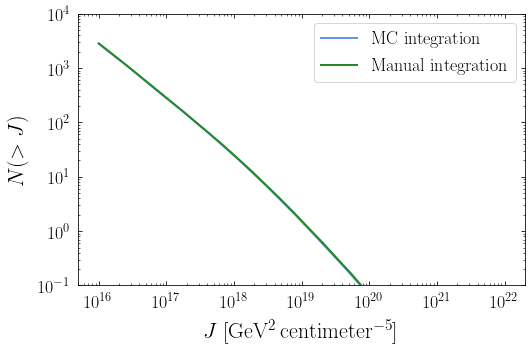

In [96]:
plt.figure(figsize=(8,5))

plt.plot(J_ary, Ncumul_ary[:,0], label="MC integration")
plt.plot(J_ary, Ncumul_manual_ary, label="Manual integration")

plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-1,1e4)

plt.xlabel("$J$ [GeV$^2$\,centimeter$^{-5}$]")
plt.ylabel("$N(>J)$")

plt.legend()

# 2. Differential SCD calculation

The same as the cumulative case, but during integration $\delta N$ is phase-space-constrained to lie between $J$ and $J + \delta J$:

$$\frac{dN}{dJ}(J) = \frac{1}{\delta J}\int_{J < J(M,l,\theta) < J + \delta J} dM\,dl\,d\theta\,\rho_M(M)\cdot 4\pi r^2 \rho_V(r),$$
making sure that the final result is not sensitive to the specific choice of $\delta J$. You may have to increase the number of points by quite a bit to get a smooth SCD!

In [17]:
# def integrand_dN(x, J_fid, dJ):
#     """ Integrand for calculating differential SCD by integrating 
#         over the mass function, distance from GC and opening angle from GC and to the Galactic plane 
#     """
    
    
#     M200, r, theta = np.exp(x[0])*M_s, np.exp(x[1])*kpc, x[2]
    
#     # If J-factor is within than specified values, add the corresponding "dN"
#     # (impose phase-space constrain)
#     l = np.sqrt(l**2 + R_sun**2 + 2*r*R_sun*np.cos(theta))
#     if J_fid < J(M200, c200_SC(M200), l)/(GeV**2*Centimeter**-5) < J_fid + dJ:
#         return 2*np.pi*np.sin(theta)*pref*r*M200*rho_M_r(M200, r)
#     else:
#         return 0.

In [57]:
# npoints = 5e6

# def dNdJ_MC(J_fid):
#     """ Perform cumulative SCD integral with scikit-monaco
#     """
#     # Set value of differential element
#     # Check to make sure the calculation is not sensitive to this choice!!
#     dJ = 1e-1*J_fid

#     dN_val, dN_err = mcmiser(integrand_dN, npoints=npoints, xl=[np.log(M_min/M_s),np.log(R_min/kpc),0], xu=[np.log(M_max/M_s), np.log(R_max/kpc), np.pi], nprocs=5, args=[J_fid, dJ])
#     return dN_val/dJ, dN_err/dJ

In [59]:
# dNdJ_ary = np.array([dNdJ_MC(J) for J in tqdm_notebook(J_ary)])

In [61]:
# deg = 180 / np.pi
# sr = 4 * np.pi
# srdeg2 = sr * deg**2

In [60]:
# plt.plot(J_ary, J_ary**2*(1/srdeg2)*dNdJ_ary[:,0]/(GeV**2*Centimeter**-5))
# plt.xscale("log")
# plt.yscale("log")
# plt.xlabel("$J$ [GeV$^2$\,centimeter$^{-5}$]")
# plt.ylabel("$J^2\,dN/dJ$ [GeV$^2$\,centimeter$^{-5}$\,deg$^{-2}$]")